# Homework 5: Photometric reverberation mapping

<span style="color:red">**Deadline:** </span> 10. June 2024. at 1PM

# Task 1

**Goal:**

- Understand the photometric reverberation mapping method and its limitations. 
- Introduction to the tools for simulating AGN light curves and performing photoRM.

<span style="color:blue">**a)**</span> Familiarize yourself with photRM module (read the docs located in photRM.py). Using the `lc_two_bands` function from the `photRM` module, construct **three pairs** of continuum and emission line light curves of length 5000 days. This is a hypothetical scenario where we generate pairs of light curves as if they are observed in two broadband filters:

   - one covering only continuum emission (we will name it *x-band*)
   - second covering emission line and the underlying continuum (we will name it *y-band*)

Make sure that the light curve pairs are simulated for the artificial AGN objects at z = 0.1 having luminosity (log L): 43, 44, and 45, respectively. The emission line contribution to the total integrated flux should be 25% and the continuum contribution 75% in all cases. Plot the first 1000 days of the light curves and compare the properties (printed when you run `lc_two_bands`) of these three simulated AGN objects. How would you explain the correlation between AGN luminosity and broad line region dimensions (i.e. time-lag)? Cut the light curve length to 1000 points and save them for later use.

In [1]:
# Standard lib
import os
import warnings

# 3rd party libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from antares_client.search import search

%matplotlib inline

# Custom libs
import photRM
from pyzdcf import pyzdcf

In [2]:
# Using the lc_two_bands function from the photRM module, construct three pairs of x-band and y-band filters 
# with length 5000 days, z = 0.1, total integrated flux should be 25%, the continuum contribution 75%

np.random.seed(0)
x_band, y_band, line_response =\
[photRM.lc_two_bands(5000,osc=True,A=0.14,noise=0.00005,z=0.1,lag='random',wl=0.25,wc=0.75,plot_kernel=False)
 for _ in range(3)]

Properties of the simulated AGN object:
---------------------------------------
log(L) = 44.01
MBH = 1.48e+07 M_sun
tau_DRW = 32.20 days
sigma_DRW = 0.03 mag^2/day
Time-lag = 34.11 days
Properties of the simulated AGN object:
---------------------------------------
log(L) = 42.64
MBH = 1.80e+06 M_sun
tau_DRW = 13.86 days
sigma_DRW = 0.06 mag^2/day
Time-lag = 6.33 days
Properties of the simulated AGN object:
---------------------------------------
log(L) = 44.83
MBH = 5.19e+07 M_sun
tau_DRW = 53.17 days
sigma_DRW = 0.01 mag^2/day
Time-lag = 92.93 days


Now, we have three simulated AGN objects with very different time-lags and varying properties as listed above.

In [3]:
x_band
# all three pairs are stored within respective variables

(         t      flux       err
 0        1  0.953782  0.004883
 1        2  0.956279  0.004889
 2        3  0.961300  0.004902
 3        4  0.953590  0.004883
 4        5  0.958023  0.004894
 ...    ...       ...       ...
 4995  4996  0.972350  0.004930
 4996  4997  0.973891  0.004934
 4997  4998  0.972469  0.004931
 4998  4999  0.964799  0.004911
 4999  5000  0.966491  0.004916
 
 [5000 rows x 3 columns],
          t      flux       err
 0        1  0.953782  0.005092
 1        2  0.955655  0.005097
 2        3  0.959421  0.005107
 3        4  0.953639  0.005092
 4        5  0.956963  0.005101
 ...    ...       ...       ...
 4995  4996  0.973564  0.005145
 4996  4997  0.974947  0.005149
 4997  4998  0.974231  0.005147
 4998  4999  0.968828  0.005132
 4999  5000  0.970330  0.005136
 
 [5000 rows x 3 columns],
          t      flux       err
 0        1  0.238446  0.004873
 1        2  0.238446  0.004873
 2        3  0.238446  0.004873
 3        4  0.238446  0.004873
 4        5  0.2

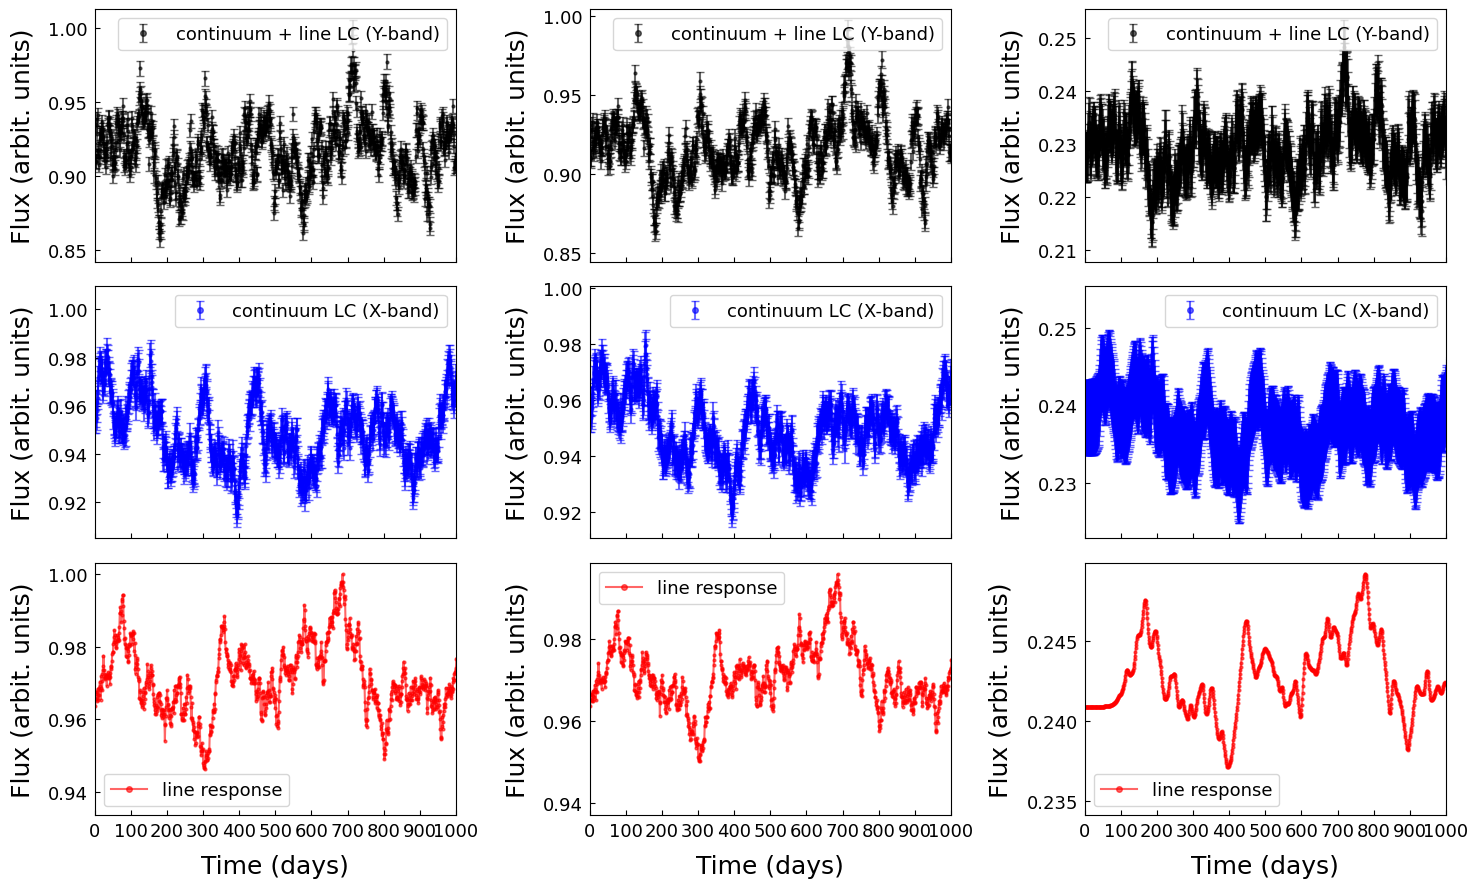

In [4]:
# Plotting the first 1000 days of the light curves    
fig, (ax1,ax2,ax3) = plt.subplots(3,3,sharex=True,figsize=(15,9),tight_layout=True)
for i in range(3):   
    ax1[i].errorbar(y_band[i]['t'],y_band[i]['flux'],yerr=y_band[i]['err'],fmt='ko',markersize=2,alpha=0.6,capsize=3,label='continuum + line LC (Y-band)')
    ax2[i].errorbar(x_band[i]['t'],x_band[i]['flux'],yerr=x_band[i]['err'],fmt='bo',markersize=2,alpha=0.6,capsize=3,label='continuum LC (X-band)')
    ax3[i].plot(line_response[i]['t'], line_response[i]['flux'],'ro-', markersize=2,alpha=0.6, label='line response')

    loc = plticker.MultipleLocator(100) # this locator puts ticks at regular intervals

    for ax in [ax1[i],ax2[i],ax3[i]]:
        ax.legend(fontsize=13,markerscale=2)
        ax.set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
        ax.tick_params(direction='in',pad=5,labelsize=13)
        ax.set_xlim(0,1000)
        ax.xaxis.set_major_locator(loc)

    ax3[i].set_xlabel('Time (days)',fontsize=18,labelpad=10)
plt.show()

- This technique measures the time delay between changes in the continuum emission from the AGN and the subsequent response in the emission line flux from the BLR. The time-lag ($\tau$) is directly proportional to the distance (R) between the AGN’s central source and the BLR, as 

$\tau = \frac{R}{c}$

where $c$ is the speed of light.

- From observations, we have established an empirical relationship between the BLR radius $R_{BLR}$ and the AGN luminosity $L$:

$R_{BLR} \propto L^{0.5}$

In [5]:
# Cutting the light curve length to 1000 points and saving them for later use
dir_path = './data/'

cut = 1000
for i in range(3):
    np.savetxt(dir_path+'x_band'+str(i),np.c_[x_band[i].t[:cut],x_band[i].flux[:cut],x_band[i].err[:cut]],fmt=['%.1f','%.7e','%.7e'])
    np.savetxt(dir_path+'y_band'+str(i),np.c_[y_band[i].t[:cut],y_band[i].flux[:cut],y_band[i].err[:cut]],fmt=['%.1f','%.7e','%.7e'])

________________

<span style="color:blue">**b)**</span> Using the photometric reverberation mapping method and the `pyzdcf` module, estimate the time-lag (broad line region radius) for these three light curve pairs. You can use the default values for keyword arguments in the function. How do the time-lag estimates compare to the values reported by `lc_two_bands`? You can estimate the time-lag using the `photRM.peak_finder` or (optionally) you can compile a Fortran code [PLIKE](https://www.weizmann.ac.il/particle/tal/research-activities/software) to obtain more accurate results and errors. Similarly display the results as in Astro Data Lab notebook.

>To install pyzdcf:
>
>   `pip install pyzdcf`
>    
>or you can run this notebook in Astro Data Lab where `pyzdcf` is already installed.

> To run PLIKE:
>
> - download the source code [here](https://webhome.weizmann.ac.il/home/tal/zdcf/plike_v4.0.f90)
> - if you don't have a fortran compiler, I suggest you install `gfortran` on your system
> - navigate to the folder containing the downloaded file
> - from there, run the following commands in the terminal:  
> `gfortran -o plike source_code_filename`  
> `./plike`

In [6]:
# pyzdcf is already installed in Astro Data Lab

In [7]:
# Set input parameters for pyZDCF
input_dir = './data/'     # Path to the input light curve data
output_dir = './results/' # Path to the directory for saving the results

# Light curve names
lcx = 'x_band'
lcy = 'y_band'

In [8]:
# Step 2: ACF calculation

# Parameters are passed to pyzdcf as a dictionary

params = [dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
            prefix            = 'acf',  # Output files prefix
            uniform_sampling  =  False, # Uniform sampling?
            omit_zero_lags    =  True,  # Omit zero lag points?
            minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
            num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
            lc1_name          =  lcx+str(i)    # Name of the light curve file
         )
for i in range(3)]

# Run pyzdcf
acf = [pyzdcf(input_dir,output_dir,intr=False,parameters=params[i],sep=' ',sparse='auto') for i in range(3)]


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs disc

In [9]:
# Step 3: CCF calculation
params = [dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lcx+str(i),   # Name of the first light curve file
              lc2_name          =  lcy+str(i)    # Name of the second light curve file
             )
for i in range(3)]

ccf = [pyzdcf(input_dir,output_dir,intr=False,parameters=params[i],sep=' ',sparse='auto') for i in range(3)]


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent p

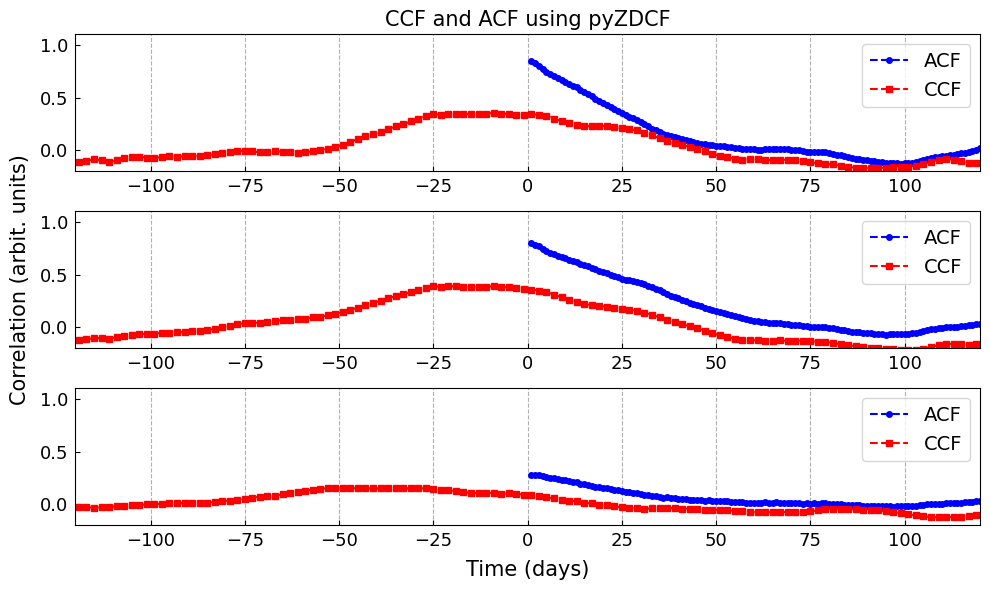

In [10]:
# Plot CCF and ACF
fig, ax = plt.subplots(3,1,figsize=(10,6),tight_layout=True)

for i in range(3):
    ax[i].plot(acf[i]['tau'],acf[i]['dcf'],'o--b',label='ACF',markersize=4)
    ax[i].plot(ccf[i]['tau'],ccf[i]['dcf'],'s--r',label='CCF',markersize=4)
    ax[i].set_xlim(-120,120)
    ax[i].set_ylim(-0.2,1.1)
    ax[i].legend(fontsize=14)
    loc = plticker.MultipleLocator(25)
    ax[i].xaxis.set_major_locator(loc)
    ax[i].tick_params(direction='in', pad = 5,labelsize=13)
    ax[i].grid(which='major',axis='x',linestyle='--')
    
ax[0].set_title('CCF and ACF using pyZDCF',fontsize=15)
ax[1].set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax[2].set_xlabel("Time (days)",fontsize=15,labelpad=7)
plt.show()

In [11]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
for i in range(3):
    print('ACF shape (original): ',acf[i].shape)

    acf[i] = photRM.add_inverted_acf(acf[i])
    print('ACF shape (inverted): ',acf[i].shape)

    acf[i] = photRM.interp(ccf[i],acf[i]) # first param is the function having the x-axis on which we want to interpolate the other function.
    print('ACF shape (interpolated): ',acf[i].shape)
    print('CCF shape: ',ccf[i].shape)
    print('--------------------------------------------')

ACF shape (original):  (990, 7)
ACF shape (inverted):  (1980, 7)
ACF shape (interpolated):  (992, 7)
CCF shape:  (992, 7)
--------------------------------------------
ACF shape (original):  (990, 7)
ACF shape (inverted):  (1980, 7)
ACF shape (interpolated):  (992, 7)
CCF shape:  (992, 7)
--------------------------------------------
ACF shape (original):  (990, 7)
ACF shape (inverted):  (1980, 7)
ACF shape (interpolated):  (992, 7)
CCF shape:  (992, 7)
--------------------------------------------


In [12]:
# Subtracting CCF and ACF
final_ccf = [photRM.delta_ccf(acf[i], ccf[i]) for i in range(3)]
final_ccf[0].head()

,tau,-sig(tau),+sig(tau),dcf,-err(dcf),+err(dcf),#bin
0,-991.0,4,1,-0.138513,0.516064,0.507090,10
1,-989.0,0,0,-0.543089,0.441067,0.442639,11
2,-987.0,0,0,-0.187822,0.424401,0.428928,13
3,-985.0,0,0,0.122813,0.383040,0.393613,15
4,-983.0,0,0,0.092030,0.308780,0.331050,17


In [13]:
# estimating the time-lag(broad line region radius) using the photRM.peak_finder
tau, peaks_x, peaks_y= [[[photRM.peak_finder(final_ccf[i].dcf.values,final_ccf[i].tau.values,(0,100)) for i in range(3)][j][k] for j in range(3)]for k in range(3)]

err_low = [final_ccf[i].loc[final_ccf[i].tau == tau[i], '-sig(tau)'].values[0] for i in range(3)]
err_high = [final_ccf[i].loc[final_ccf[i].tau == tau[i], '+sig(tau)'].values[0] for i in range(3)]

Peak candidates (x-axis vals):  [37. 41. 45. 61. 67. 73.]
Max. peak:  45.0
Peak candidates (x-axis vals):  [47. 53. 61. 75. 81. 85. 91. 95.]
Max. peak:  85.0
Peak candidates (x-axis vals):  [51. 55. 65. 85.]
Max. peak:  85.0
Peak candidates (x-axis vals):  [37. 41. 45. 61. 67. 73.]
Max. peak:  45.0
Peak candidates (x-axis vals):  [47. 53. 61. 75. 81. 85. 91. 95.]
Max. peak:  85.0
Peak candidates (x-axis vals):  [51. 55. 65. 85.]
Max. peak:  85.0
Peak candidates (x-axis vals):  [37. 41. 45. 61. 67. 73.]
Max. peak:  45.0
Peak candidates (x-axis vals):  [47. 53. 61. 75. 81. 85. 91. 95.]
Max. peak:  85.0
Peak candidates (x-axis vals):  [51. 55. 65. 85.]
Max. peak:  85.0
Peak candidates (x-axis vals):  [37. 41. 45. 61. 67. 73.]
Max. peak:  45.0
Peak candidates (x-axis vals):  [47. 53. 61. 75. 81. 85. 91. 95.]
Max. peak:  85.0
Peak candidates (x-axis vals):  [51. 55. 65. 85.]
Max. peak:  85.0
Peak candidates (x-axis vals):  [37. 41. 45. 61. 67. 73.]
Max. peak:  45.0
Peak candidates (x-axis v

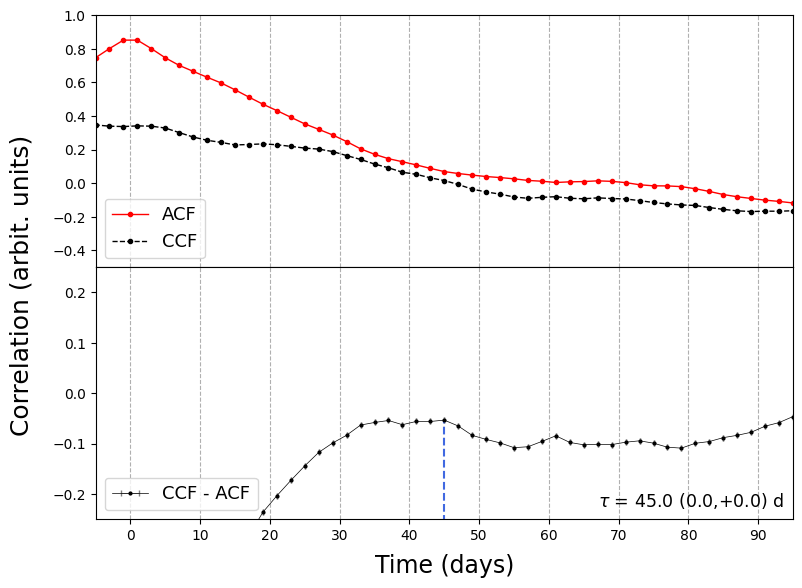

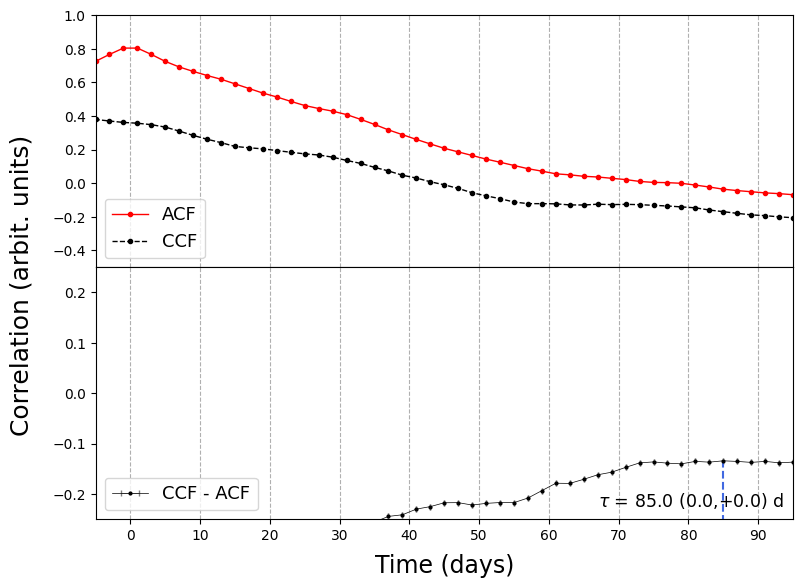

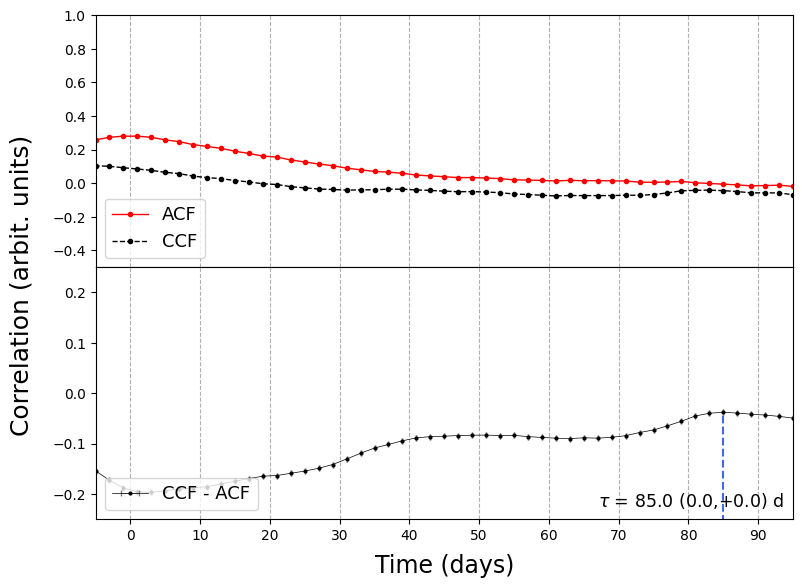

In [14]:
lims_x = (-5,95)
lims_y = (-0.5,1)
err = [(err_low[i]*(-1), err_high[i]) for i in range(3)]

for i in range(3):
    photRM.plot_ccf_acf(final_ccf[i],ccf[i],acf[i],locator=10,peak=True,tau=tau[i],err=err[i],lims_x=lims_x,lims_y=lims_y)

- Time-lag estimated: **45 days** (real value = 34.11 days)

- Time-lag estimated: **85 days** (real value =  6.33 days)

- Time-lag estimated: **85 days** (real value = 92.93 days)
________________

<span style="color:blue">**c) (optional)**</span> Now, to reflect a real-world scenario, let's make one of these three pairs of simulated light curves gappier (e.g., the one with log(L) = 44). Alter the light curves so they have the following cadences:

- one observation every 5 days
- one months of observations every day, then one month pause. Repeat the pattern.
- three month of observations every day, followed by six months of observations with a frequency of once per month and then a gap of three months. Repeat the pattern.

Estimate the time-lag from these three pairs of light curves. Write your conclusions regarding the accuracy of time-lag retrieval for different observing strategies you implemented. The light curves should not be longer than 1000 days.

# Task 2

**Goal:** Apply photometric reverberation mapping to real-world data.

Download photometric light curves of NGC 4395 from Edri et al. (2012). Choose one filter which covers the continuum emission only and the other one that covers the H$\alpha$ emission line and the underlying continuum. Using the utility functions provided, process the data so that time is expressed in hours and line intensity and its error are expressed as normalized flux. Plot the light curves. You will see that they are divided into segments because we have a pause in observations during the daylight. Choose the first segment and estimate the time lag using this data. Compare your results to Edri et al. (2012) and discuss the pros and cons of photometric reverberation mapping compared to spectroscopic reverberation mapping.

In [15]:
# Read the light curves using pd.read_csv()

r = pd.read_csv("obs_data/lc_r.txt", sep='\s+')
g = pd.read_csv("obs_data/lc_g.txt", sep='\s+')
i = pd.read_csv("obs_data/lc_i.txt", sep='\s+')
r.head()

,MJD,mag,mag_err
0,2.455616e+06,16.272,0.027
1,2.455616e+06,16.270,0.026
2,2.455616e+06,16.263,0.022
3,2.455616e+06,16.260,0.021
4,2.455616e+06,16.251,0.021


In [16]:
# Light curve processing utility function

from lc_proc import lc_proc
# help(lc_proc)

lcs = [g,r,i]
filters = ['g', 'r', 'i'] # see lc_proc docs for accepted values for filters
new_lcs = lc_proc(lcs, filters)
new_lcs[0].head()

,MJD,mag,mag_err,time_hours,flux,flux_err,norm_flux,norm_flux_err
0,2.455616e+06,17.289,0.019,0.00000,1344.002263,25.536043,0.331021,0.089621
1,2.455616e+06,17.264,0.022,0.23232,1375.308097,30.256778,0.440891,0.106189
2,2.455616e+06,17.274,0.015,0.46464,1362.699197,20.440488,0.396639,0.071738
3,2.455616e+06,17.261,0.019,0.69720,1379.113469,26.203156,0.454246,0.091962
4,2.455616e+06,17.258,0.015,0.92952,1382.929370,20.743941,0.467639,0.072803


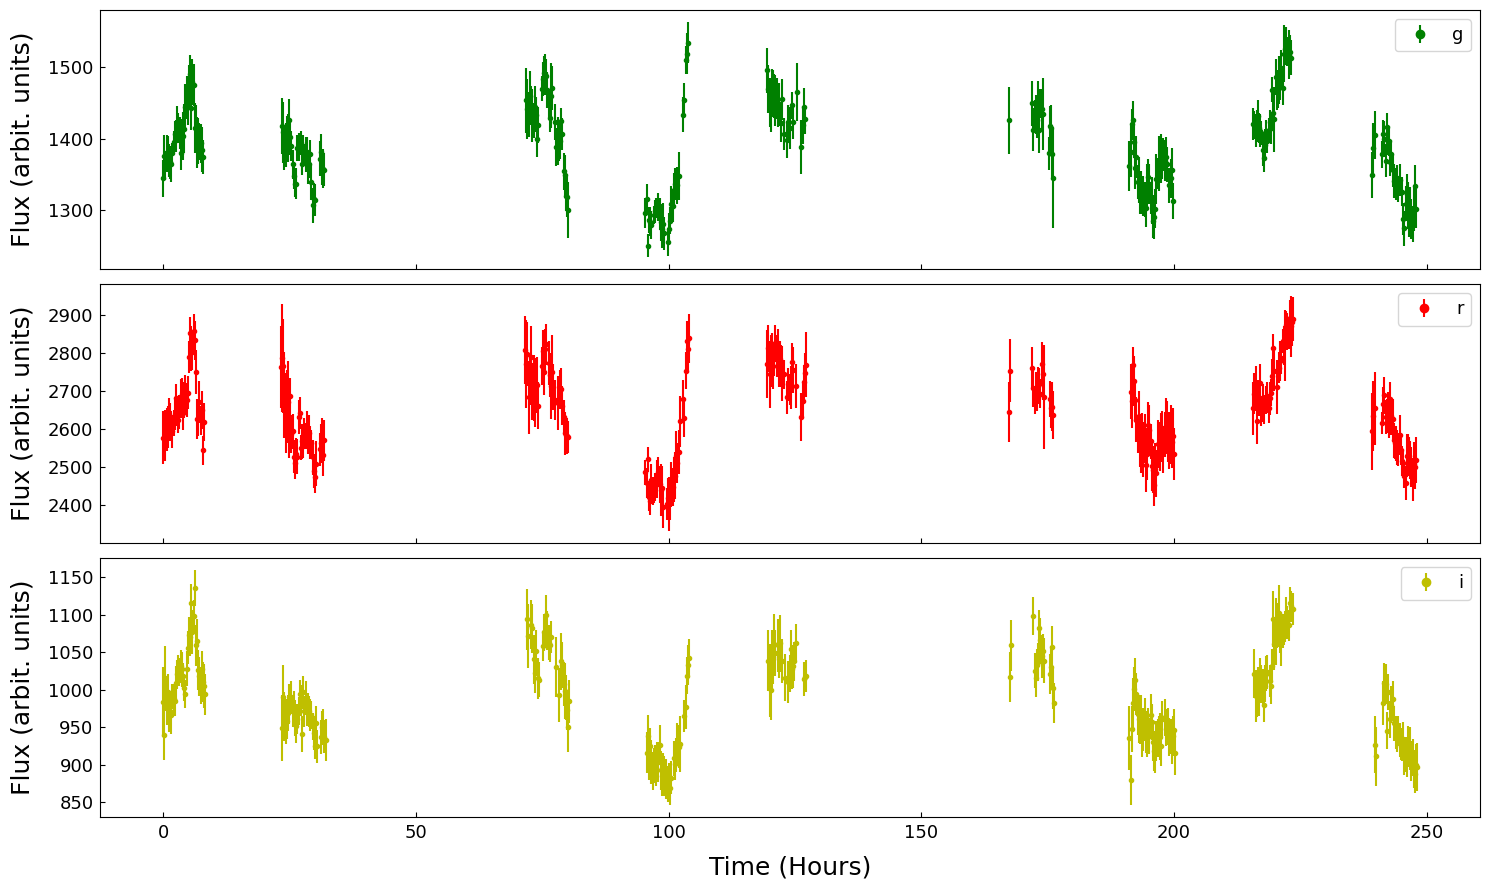

In [17]:
# Plotting the first 1000 days of the light curves    
fig, ax = plt.subplots(3,1,sharex=True,figsize=(15,9),tight_layout=True)

ax[0].errorbar(new_lcs[0]['time_hours'], new_lcs[0]['flux'],yerr=new_lcs[0]['flux_err'],fmt='go', markersize=3, label='g')
ax[1].errorbar(new_lcs[1]['time_hours'], new_lcs[1]['flux'],yerr=new_lcs[1]['flux_err'], fmt='ro', markersize=3, label='r')
ax[2].errorbar(new_lcs[2]['time_hours'], new_lcs[2]['flux'],yerr=new_lcs[2]['flux_err'], fmt='yo', markersize=3, label='i')

for j in range(3):
    ax[j].legend(fontsize=13,markerscale=2)
    ax[j].set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
    ax[j].tick_params(direction='in',pad=5,labelsize=13)

ax[2].set_xlabel('Time (Hours)',fontsize=18,labelpad=10)
plt.show()

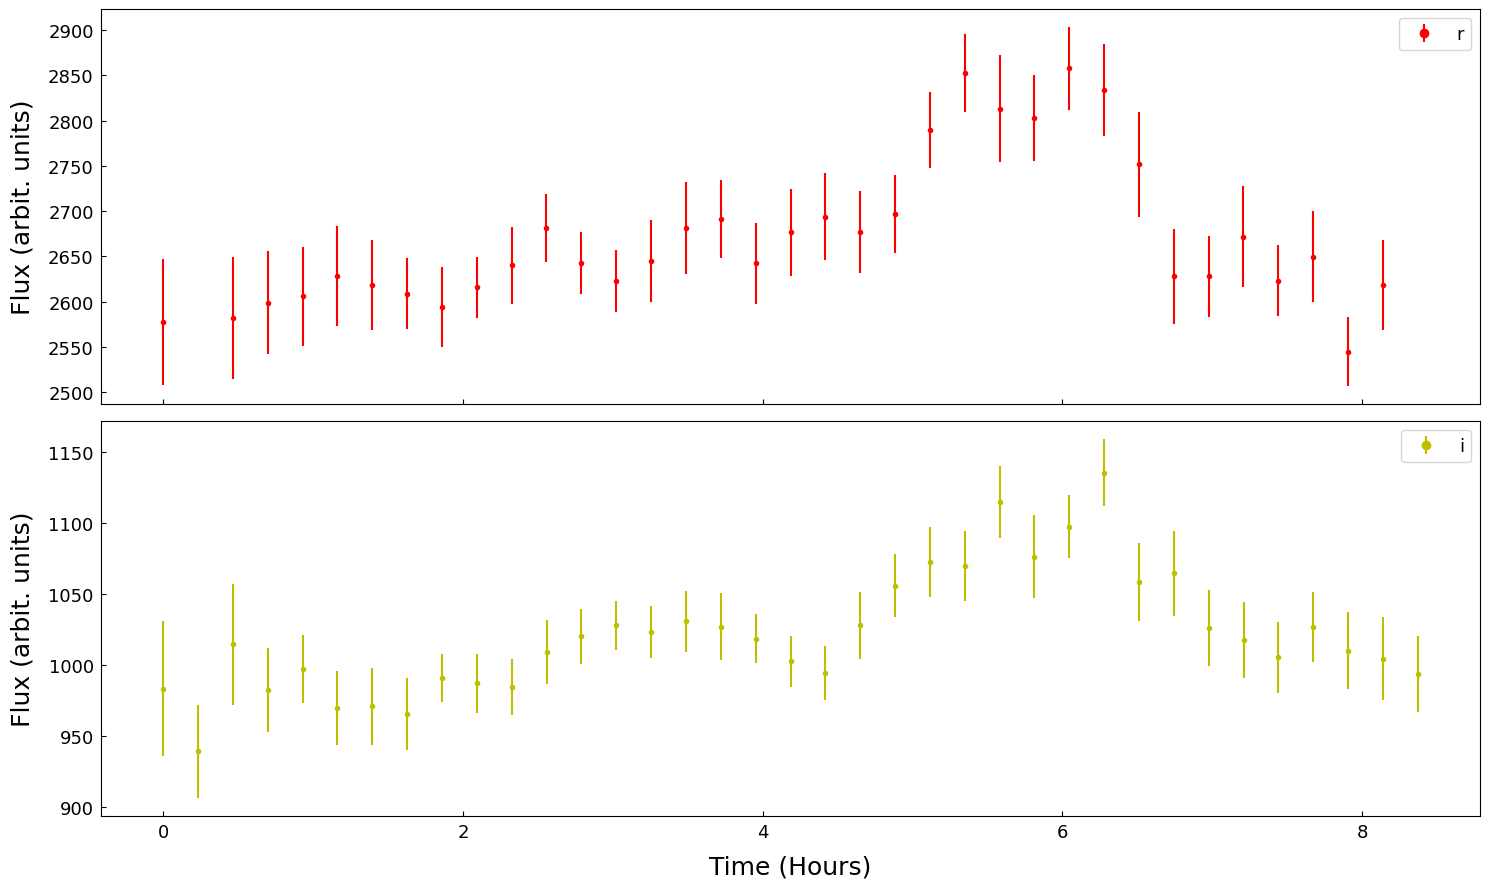

In [18]:
# Choosing the first segment of the data

lc_r = new_lcs[1]
lc_i = new_lcs[2]
lc_r_seg1 = lc_r[lc_r['time_hours']<9]
lc_i_seg1 = lc_i[lc_i['time_hours']<9]

# Save the data

dir_path ='./data/'

np.savetxt(dir_path+'lc_i.txt', np.c_[lc_i_seg1['time_hours'],lc_i_seg1['norm_flux'],lc_i_seg1['norm_flux_err']],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'lc_r.txt', np.c_[lc_r_seg1['time_hours'],lc_r_seg1['norm_flux'],lc_r_seg1['norm_flux_err']],fmt=['%.1f','%.7e','%.7e'])

fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,9),tight_layout=True)

ax[0].errorbar(lc_r_seg1['time_hours'], lc_r_seg1['flux'],yerr=lc_r_seg1['flux_err'], fmt='ro', markersize=3, label='r')
ax[1].errorbar(lc_i_seg1['time_hours'], lc_i_seg1['flux'],yerr=lc_i_seg1['flux_err'], fmt='yo', markersize=3, label='i')

for j in range(2):
    ax[j].legend(fontsize=13,markerscale=2)
    ax[j].set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
    ax[j].tick_params(direction='in',pad=5,labelsize=13)
    
ax[1].set_xlabel('Time (Hours)',fontsize=18,labelpad=10)
plt.show()

In [19]:
input_dir = './data/'     # Path to the input light curve data
output_dir = './results/' # Path to the directory for saving the results

lcr = 'lc_r.txt' # r-band -- Halpha + continuum -- y-band
lci = 'lc_i.txt' # i-band -- pure continuum -- x-band

# ACF calculation

params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lci   # Name of the light curve file
             )

acf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# CCF calculation

params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lci,   # Name of the first light curve file
              lc2_name          =  lcr    # Name of the second light curve file
             )

ccf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# Interpolating

acf = photRM.interp(ccf,acf)
final_ccf = photRM.delta_ccf(acf, ccf)

# # Estimating time lag

tau, peaks_x, peaks_y = photRM.peak_finder(final_ccf.dcf.values,final_ccf.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf.tau == tau, '+sig(tau)'].values[0]


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

35 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

64 bins actually used, 164 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.

Peak candidates (x-axis vals):  [0.30000001 0.5        1.20000005 1.76315788 2.0888888  2.47058826
 2.7833333  3.5        3.88461546 4.74545453]
Max. peak:  4.745454528115013


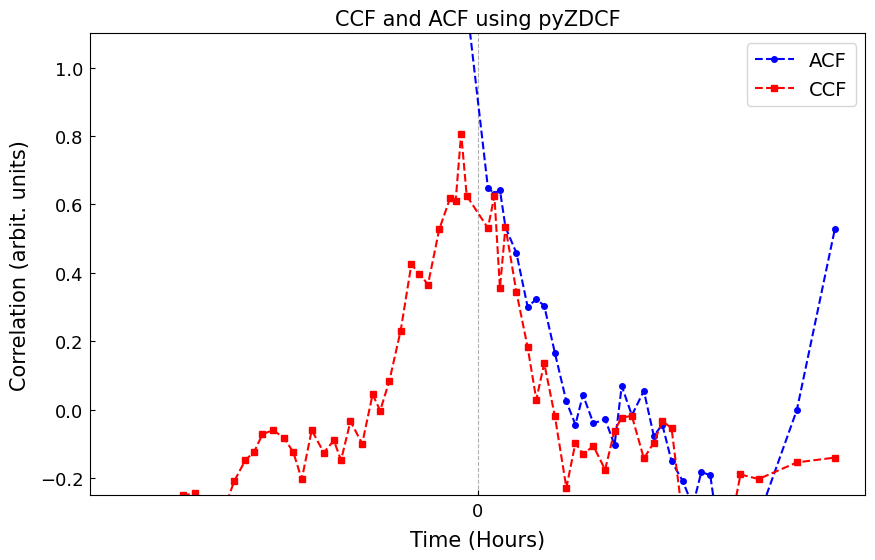

In [20]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf['tau'],acf['dcf'],'o--b',label='ACF',markersize=4)
ax.plot(ccf['tau'],ccf['dcf'],'s--r',label='CCF',markersize=4)

ax.set_xlim(-7,7)
ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (Hours)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

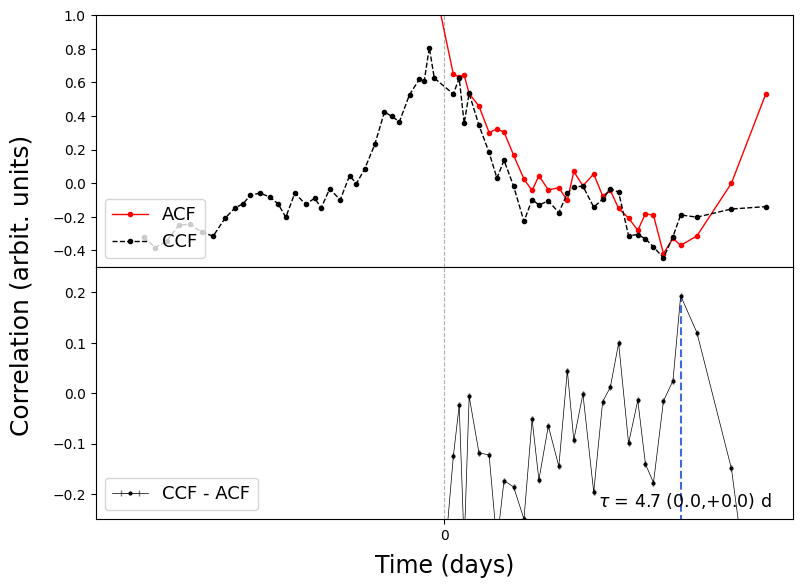

In [21]:
lims_x = (-7,7)
lims_y = (-0.5,1)
err = (err_low*(-1), err_high)

photRM.plot_ccf_acf(final_ccf,ccf,acf,locator=10,peak=True,tau=tau,err=err,lims_x=lims_x,lims_y=lims_y)
# note that the time here is in hours not days

- According to Edri et al.(2012)  the time lag is 3.6 +/- 0.8 hours and here we have estimated **4.7 hours**.
- This is quite a close match and displays the reliability of the photometric reverberation mapping technique.

**Pros:**

- Photometric observations are generally simpler and easier than spectroscopic ones. It can be performed with smaller telescopes and less sophisticated equipment.
- Photometric data can be obtained more frequently, providing higher temporal resolution which is useful for monitoring rapid variability in AGNs.
- Photometric surveys often have a wider field of view, allowing for simultaneous monitoring of multiple AGNs.

**Cons:**

- In PhotoRM, the light from emission lines is blended with the continuum emission and requires careful separation of the continuum and line contributions.
- Spectroscopic RM provides more precise measurements of the emission line profiles and their variations. PhotoRM can suffer from higher uncertainties in time lag estimation.
- PhotoRM does not provide detailed spectral information, such as line widths and shapes, which help to better understand the kinematics and structure of the BLR.

# References:

- Edri et al. (2012) https://ui.adsabs.harvard.edu/abs/2012ApJ...756...73E/abstract
- Jankov et al. (2022) https://ui.adsabs.harvard.edu/abs/2022AN....34310090J/abstract
- Kovacevic et al. (2021) https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract
- [Astro Data Lab](https://datalab.noirlab.edu/)
- [pyzdcf documentation](https://pyzdcf.readthedocs.io/en/latest/?badge=latest)
- [PLIKE download link](https://www.weizmann.ac.il/particle/tal/research-activities/software)